In [ ]:
import numpy as np
# ------ helper: azimuth conversions ----------
def _north_to_east(az_north_deg: float) -> float:
    """
    Convert an azimuth defined with 0° = North, clockwise positive
    to the mathematical convention 0° = East, counter-clockwise positive.
    """
    return (90.0 - az_north_deg) % 360.0


def _east_to_north(az_east_deg: float) -> float:
    """
    Convert an azimuth defined with 0° = East, CCW positive
    back to 0° = North, clockwise positive.
    """
    return (90.0 - az_east_deg) % 360.0

# ---------- 2) ray–sphere intersection with satellite shell ----------
def compute_satellite_intersection_point_enu(
        az_deg: float, el_deg: float, sat_orbit_m: float, tx_pos=None):
    """
    Given azimuth (north-0°, CW) and elevation (0° = horizon, 90° = zenith),
    find the intersection of the ray from `tx_pos` with the spherical
    shell of radius Earth + sat_orbit_m.

    Returns:
        point_enu  – (E, N, U) vector from `tx_pos` to the intersection (m)
        delay_ms   – propagation delay (ms) assuming speed c = 3e8 m/s
        distance_m – geometric distance (m)
    """
    R_e = 6371e3
    sat_r = R_e + sat_orbit_m
    c = 3e8

    # Default TX at (lat=0, lon=0, altitude 0)
    if tx_pos is None:
        tx_pos = np.array([0.0, 0.0, R_e])

    # Direction unit vector in E, N, U
    az_east = np.radians(_north_to_east(az_deg))
    el_rad  = np.radians(el_deg)
    d = np.array([
        np.cos(el_rad) * np.cos(az_east),   # East
        np.cos(el_rad) * np.sin(az_east),   # North
        np.sin(el_rad)                      # Up
    ])

    # Quadratic for ray–sphere intersection: ‖o + t·d‖ = sat_r
    o = tx_pos
    a = np.dot(d, d)
    b = 2 * np.dot(o, d)
    c_quad = np.dot(o, o) - sat_r ** 2
    disc = b * b - 4 * a * c_quad
    if disc < 0:
        raise ValueError("Ray does not intersect satellite shell")

    t1 = (-b - np.sqrt(disc)) / (2 * a)
    t2 = (-b + np.sqrt(disc)) / (2 * a)
    t  = min(t for t in (t1, t2) if t > 0)  # first positive root

    point_ecef = o + t * d
    point_enu  = point_ecef - tx_pos
    dist_m     = np.linalg.norm(point_enu)
    delay_ms   = dist_m / c * 1e3
    return point_enu, delay_ms, dist_m


# ---------- 3) azimuth, elevation, distance between two points ----------
def compute_az_el_dist(sat_pos, gnd_pos, frequency_hz: float | None = None):
    """
    Given satellite and ground positions in the same Cartesian frame
    (E, N, U or ECEF), return:

        az_deg : azimuth (0° = North, clockwise)
        el_deg : elevation
        dist   : distance in metres
        n_waves: number of wavelengths (optional, if frequency_hz given)
    """
    vec  = sat_pos - gnd_pos
    dist = np.linalg.norm(vec)
    dx, dy, dz = vec / dist                            # normalised vector (E, N, U)

    el_rad = np.arcsin(dz)
    az_east = np.arctan2(dy, dx)                       # 0° = East, CCW
    az_deg  = _east_to_north(np.degrees(az_east))      # convert back to North-0°

    el_deg = np.degrees(el_rad)

    if frequency_hz is not None:
        wavelength = 3e8 / frequency_hz
        n_waves = dist / wavelength
        return az_deg, el_deg, dist, n_waves
    return az_deg, el_deg, dist


In [2]:
c = 3e8  # speed of light (m/s)
fc = 10e9  # Carrier frequency: 10 GHz
wavelength = c / fc
bandwidth = 100e6  # 100 MHz
tx_power_dbm = 50  #  75 W- 100W 48.75-50.00 dBm
jam_power_dbm = 60
k = 1.38e-23  # Boltzmann 
GT = 13 # db gain-to-noise-temperature for for 0.33m Equivalent satellite antenna aperturesatellites, or can be 5 dB K^(-1) for 0.13m Equivalent satellite antenna aperture
La = 5 # dB
GT_linear_inv = 10 ** (-GT / 10)
La_linear = 10 ** (La / 10)
noise_power_watt = k * bandwidth * GT_linear_inv * La_linear
Tx_power_watt = 10 ** ((tx_power_dbm  - 30)/ 10)  
Jam_power_watt = 10 ** ((jam_power_dbm  - 30)/ 10)

N0 = noise_power_watt

T_sys = 300.0  # K  realistic mid-value for LEO sat RX
N0 = 1.38e-23 * 100e6 * T_sys*La_linear
P0 = Tx_power_watt
P1 = Jam_power_watt


In [17]:
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu, compute_az_el_dist
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from minmax_solvers import (
    solve_game_bestresp_Q0_then_Q1,
    compute_J
)
from CloseBF import jammeraware_Q
from Dishjammersolver import optimal_Q0
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu
from sionna.rt import PlanarArray
from numpy.linalg import cholesky, solve, eigh


# Generate RX positions
jam_dist = 5
# distances_km = [5,15,10,20]
# distances_km = [jam_dist,jam_dist,jam_dist,jam_dist,jam_dist,jam_dist,jam_dist,jam_dist]
# distances_km = [jam_dist,jam_dist,jam_dist,jam_dist]
distances_km = [jam_dist]
azimuths_deg = np.linspace(0, 360, len(distances_km), endpoint=False)
gnd_positions = [np.array([0.0, 0.0, 0.0])]

for d_km, az in zip(distances_km, azimuths_deg):
    pos = arc_point_on_earth(d_km, az)
    gnd_positions.append(pos)
gnd_positions = np.array(gnd_positions)

for i, pos in enumerate(gnd_positions):
    print(f"TX{i}(m): {pos}")


# Compute SAT intersection points

sat_orbit_m = 550e3
# angles = [(117.88, 56.2),(230.22, 72.96), (198,60.5),(345.49,65.65), (272.81, 60.03)]
# angles = [(1, 90-(1e-9))]
# angles = [(45, 90-(1e-3)), (120, 87), (80,83), (65, 82),(130,80)]
angles = [(117.88, 56.2),(230.22, 72.96), (198,60.5),(345.49,65.65), (272.81, 60.03)]
sat_positions = []
delays_ms = []
fspl_db = []
frequency_hz = 10e9 
wavelength = 3e8 / frequency_hz

for az, el in angles:
    pos, delay, dist = compute_satellite_intersection_point_enu(az, el, sat_orbit_m)
    sat_positions.append(pos)
    delays_ms.append(delay)
    fspl = 20 * np.log10(4 * np.pi * dist / wavelength)
    fspl_db.append(fspl)

sat_positions = np.array(sat_positions)
delays_ms = np.array(delays_ms)
fspl_db = np.array(fspl_db)

print("\nSatellite Pos [m]:\n", sat_positions)
# print("\nPropagation delays [ms]:\n", delays_ms)
# print("\nFree-space path loss [dB]:\n", fspl_db)


# Compute az/el/dist per TX-SAT
  
for i, tx in enumerate(gnd_positions):
    print(f"\nFrom TX{i}:")
    for j, sat in enumerate(sat_positions):
        az, el, dist, n_waves = compute_az_el_dist(sat, tx, frequency_hz)
        print(f"  SAT{j}: az={az:.2f}°, el={el:.2f}°, dist={dist:.2f} m, λ count ≈ {n_waves:.2f}")


TX0(m): [0. 0. 0.]
TX1(m): [ 3.06161668e-13  4.99999949e+03 -1.96201528e+00]

Satellite Pos [m]:
 [[ 319854.91754542 -169211.53699735  540533.93158632]
 [-129068.57179949 -107459.57390356  547961.97010434]
 [ -94964.92920852 -292271.99923408  543173.82922097]
 [ -61865.18648533  239042.80666797  545593.97646569]
 [-312696.9941338    15348.14137418  542915.39031366]]

From TX0:
  SAT0: az=117.88°, el=56.20°, dist=650474.17 m, λ count ≈ 21682472.28
  SAT1: az=230.22°, el=72.96°, dist=573121.78 m, λ count ≈ 19104059.40
  SAT2: az=198.00°, el=60.50°, dist=624082.58 m, λ count ≈ 20802752.70
  SAT3: az=345.49°, el=65.65°, dist=598866.89 m, λ count ≈ 19962229.66
  SAT4: az=272.81°, el=60.03°, dist=626715.32 m, λ count ≈ 20890510.78

From TX1:
  SAT0: az=118.58°, el=56.03°, dist=651794.35 m, λ count ≈ 21726478.47
  SAT1: az=228.93°, el=72.65°, dist=574082.16 m, λ count ≈ 19136071.89
  SAT2: az=197.72°, el=60.12°, dist=626441.47 m, λ count ≈ 20881382.44
  SAT3: az=345.19°, el=66.07°, dist=59689

In [4]:
from sionna.rt import Receiver, Transmitter, PlanarArray, PathSolver, load_scene
import numpy as np
import vsat_dish_3gpp


def compute_cir(tx_pos, rx_pos, tx_array, rx_array,tx_look_at, rx_look_at, frequency=10e9):
    """
    Compute CIR from a single transmitter to multiple receivers using synthetic arrays.
    
    Args:
        tx_pos:        (3,) list or np.array for transmitter position
        rx_pos_array:  (m,3) array of receiver positions
        tx_array:      PlanarArray for the transmitter
        rx_array:      PlanarArray for all receivers (shared)
        frequency:     Frequency in Hz

    Returns:
        a_list:    list of CIR amplitude arrays, one per RX
        tau_list:  list of delay arrays, one per RX
    """
    scene = load_scene()
    scene.frequency = frequency
    scene.synthetic_array = True
    
    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 

    # Add transmitter
    scene.tx_array = tx_array
    tx = Transmitter(name="tx", position=tx_pos, display_radius=200)
    scene.add(tx)
    
    earth_radius_m = 6371e3
    rx_look_at2 = np.array([0.0, 0.0, -1*earth_radius_m/2])
    
    if isinstance(tx_look_at, str) and tx_look_at.lower() in ["up-z", "up", "z"]:
        tx_look_at = np.array(tx_pos) + np.array([0.0, 0.0, 100.0])
    tx.look_at(tx_look_at)
    # Add receivers
    scene.rx_array = rx_array
    rx_list = []
    for i, rx_pos in enumerate(rx_pos):
        rx = Receiver(name=f"rx{i}", position=rx_pos)
        scene.add(rx)
        rx.look_at(rx_look_at2)
        rx_list.append(rx)
    tx.look_at( tx_look_at)

    # Solve paths
    solver = PathSolver()
    paths = solver(scene=scene,
                   max_depth=0,
                   los=True,
                   synthetic_array=True,
                #    seed=41
                   )

    # Get CIRs
    a_all, tau_all = paths.cir(normalize_delays=False, out_type="numpy")

    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 
    
    return a_all, tau_all

jam_rows =1
jam_cols = 1
jam_antennas = jam_cols*jam_rows

sat_rows = 1
sat_cols = 1
sat_antennas = sat_cols*sat_rows

tx_rows = 8
tx_cols = 8
tx_antennas = tx_cols*tx_rows

tx_array = PlanarArray(num_rows=tx_rows, num_cols=tx_cols,
                        vertical_spacing=0.5, horizontal_spacing=0.5,
                        pattern="tr38901", polarization="V")
                        # pattern="iso", polarization="V")

jam_array = PlanarArray(num_rows=jam_rows, num_cols=jam_cols,  
                            vertical_spacing=0.5, horizontal_spacing=0.5,
                            pattern="vsat_dish",
                            # pattern="tr38901",
                            polarization="V")

sat_array = PlanarArray(num_rows=sat_rows, num_cols=sat_cols,
                             vertical_spacing=0.5, horizontal_spacing=0.5,
                            #  pattern="tr38901",
                             pattern="iso",
                             polarization="V")

def collapse_channel(a_cir, t_idx=0):
    """
    Collapse channel tensor at a given time index.
    Input:
      a_cir: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
    Output:
      H_t: (M, N), M = num_rx*num_rx_ant, N = num_tx*num_tx_ant
    """
    nr, nra, nt, nta, npaths, ntimes = a_cir.shape
    assert 0 <= t_idx < ntimes
    H_t = a_cir[..., t_idx]             # select time slice
    H_t = H_t.sum(axis=-1)              # sum over paths
    H_t = H_t.reshape(nr*nra, nt*nta)   # merge Rx/Tx antennas
    return H_t


In [15]:
from Dishjammersolver import optimal_Q0
a_tx,  tau_tx  = compute_cir(gnd_positions[0], sat_positions, tx_array,  sat_array,
                                np.array(gnd_positions[0]) + np.array([0.0, 0.0, 100.0]), gnd_positions[0])


# a_tx,  tau_tx  = compute_cir(gnd_positions[0], sat_positions, tx_array,  sat_array,
#                                 sat_positions[0], gnd_positions[0])


a_jam, tau_jam = compute_cir(gnd_positions[1], sat_positions, jam_array,  sat_array,
                                sat_positions[0], gnd_positions[0])


H0_full = collapse_channel(a_tx)   # shape: (K*Nr, Nt0)
H1_full = collapse_channel(a_jam)  # shape: (K*Nr, Nt1)

k_sel = 5
H_tx = H0_full[:k_sel*sat_antennas, :]
H_jam = H1_full[:k_sel*sat_antennas, :]
Q0, Q1, _, C_water = optimal_Q0( H_tx, H_jam, N0, P0, P1)
Q0, Q1, _, C_water = optimal_Q0( H_tx, H_jam, N0, 100, 100)
print("Capacity [bit/s/Hz] =", C_water)
print(np.linalg.matrix_rank(Q0))
print(np.linalg.matrix_rank(Q1))

Capacity [bit/s/Hz] = 0.33954027798304964
2
1


/tmp/ipykernel_50213/3734551054.py:105: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[i, j] = float(np.real(a.conj().T @ Q @ a))


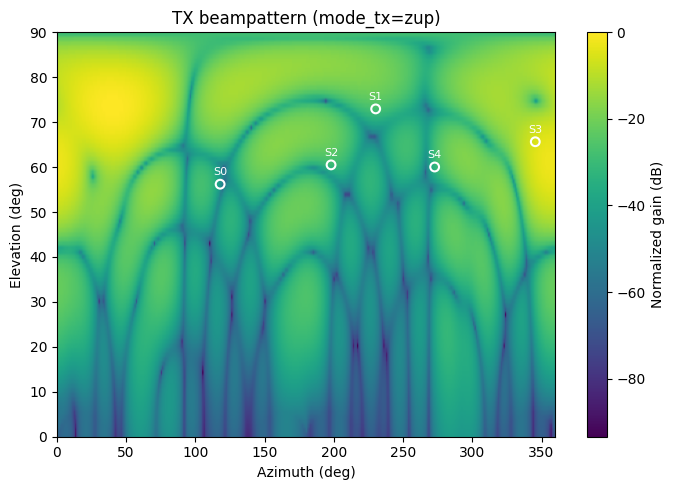

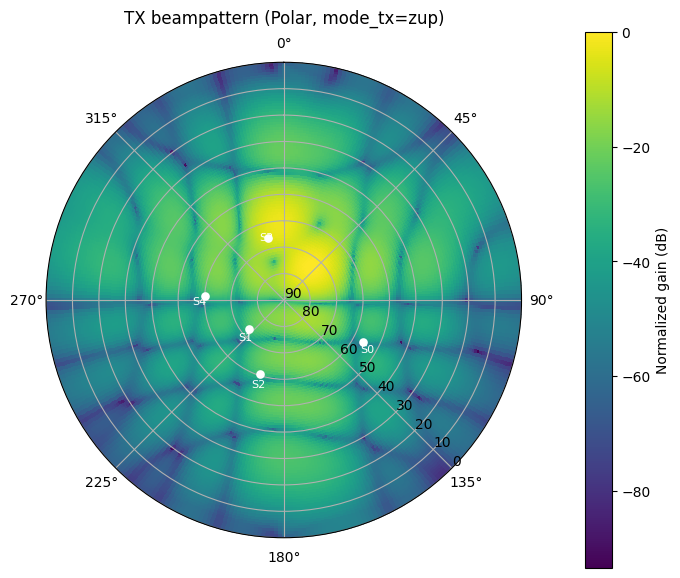

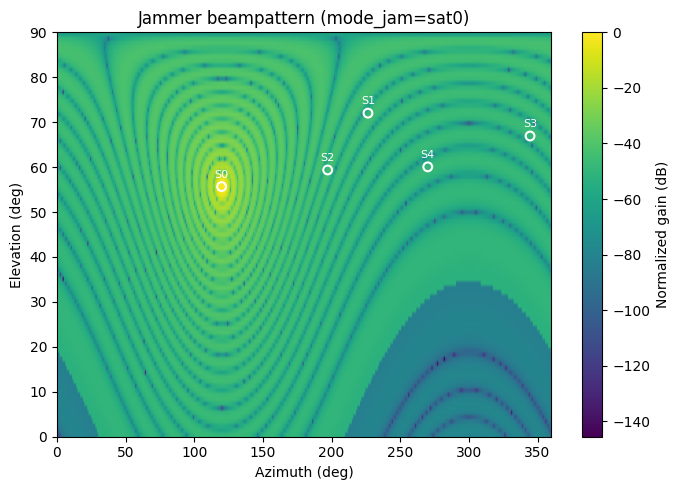

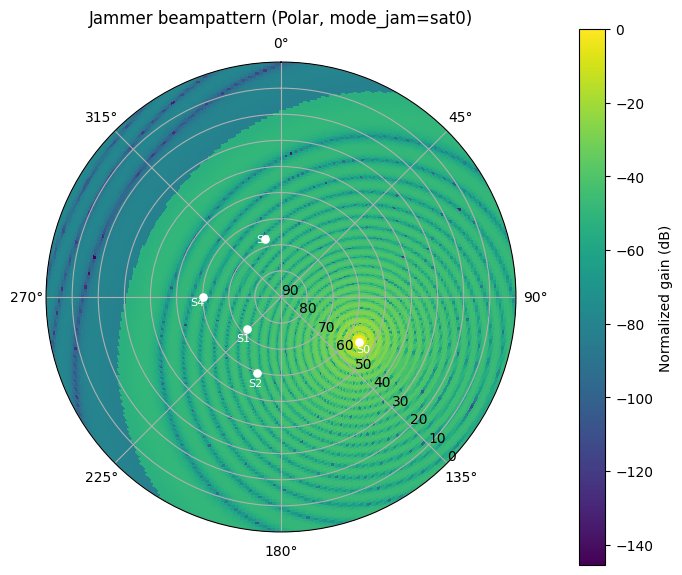

In [16]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv as Jv

# =========================
# 角度/坐标工具
# =========================
def _azel_to_unitvec(az_deg: float, el_deg: float):
    az = np.deg2rad(az_deg); el = np.deg2rad(el_deg)
    x = np.cos(el) * np.cos(az)
    y = np.cos(el) * np.sin(az)
    z = np.sin(el)
    return np.array([x, y, z], dtype=float)

def _local_basis_from_boresight(az0_deg: float, el0_deg: float,
                                up_global=np.array([0.0, 0.0, 1.0])):
    # x' = boresight
    x_prime = _azel_to_unitvec(az0_deg, el0_deg)
    x_prime = x_prime / (np.linalg.norm(x_prime) + 1e-15)
    # z' ⟂ x' 且尽量贴近 global +z
    up = up_global / (np.linalg.norm(up_global) + 1e-15)
    z_prime = up - np.dot(up, x_prime) * x_prime
    if np.linalg.norm(z_prime) < 1e-12:
        alt = np.array([1.0, 0.0, 0.0])
        if abs(np.dot(alt, x_prime)) > 0.9:
            alt = np.array([0.0, 1.0, 0.0])
        z_prime = alt - np.dot(alt, x_prime) * x_prime
    z_prime = z_prime / (np.linalg.norm(z_prime) + 1e-15)
    # y' = z' × x'
    y_prime = np.cross(z_prime, x_prime)
    y_prime = y_prime / (np.linalg.norm(y_prime) + 1e-15)
    # R 的列是本地基：v_local = R^T v_global
    R = np.stack([x_prime, y_prime, z_prime], axis=1)
    return R

def _wrap_to_pi(phi_rad: float):
    phi = phi_rad + np.pi
    phi = phi - np.floor(phi/(2.0*np.pi)) * 2.0*np.pi
    phi = phi - np.pi
    return phi

# =========================
# 元件方向图（dBi）
# =========================
def tr38901_elem_gain_db_centered(az_deg, el_deg, az0_deg, el0_deg,
                                  Gmax=8.0, phi_3dB=65.0, theta_3dB=65.0,
                                  Am=30.0, SLA_v=30.0):
    """TR 38.901 元件（与 Sionna 的 v_tr38901_pattern 一致），boresight=(az0,el0)，返回 dBi。"""
    R = _local_basis_from_boresight(az0_deg, el0_deg)
    v_g = _azel_to_unitvec(az_deg, el_deg)
    v_local = R.T @ v_g
    zc = np.clip(v_local[2], -1.0, 1.0)
    theta = np.arccos(zc)                      # [0,pi]
    phi   = np.arctan2(v_local[1], v_local[0]) # [-pi,pi]
    phi   = _wrap_to_pi(phi)
    theta_deg = np.rad2deg(theta); phi_deg = np.rad2deg(phi)
    A_v = -min(12.0*((theta_deg-90.0)/theta_3dB)**2, SLA_v)
    A_h = -min(12.0*((phi_deg)/phi_3dB)**2, Am)
    A   = -min(-(A_v + A_h), Am)
    return float(Gmax + A)

def dish_elem_gain_db_centered(az_deg, el_deg, az0_deg, el0_deg,
                               aperture_radius_lambda=10.0, g_peak_dBi=40.0,
                               back_supp_db=30.0):
    """Airy/Bessel 碟形（与你的 vsat_dish 模式一致），boresight=(az0,el0)，返回 dBi。"""
    v  = _azel_to_unitvec(az_deg, el_deg)
    v0 = _azel_to_unitvec(az0_deg, el0_deg)
    cos_a = np.clip(np.dot(v, v0), -1.0, 1.0)
    alpha = np.arccos(cos_a)
    u = 2.0*np.pi*float(aperture_radius_lambda)*np.sin(alpha)
    eps = 1e-12
    u_safe = np.where(np.abs(u) < eps, eps, u)
    airy = (2.0*Jv(1, u_safe)/u_safe)**2
    airy = np.where(np.abs(u) < eps, 1.0, airy)
    G_lin = (10.0**(g_peak_dBi/10.0))*airy
    G_lin = np.where(alpha>(np.pi/2.0), G_lin*10.0**(-back_supp_db/10.0), G_lin)
    return float(10.0*np.log10(max(G_lin, 1e-30)))

# =========================
# 阵列功率分布
# =========================
def planar_steering_vector(n_rows, n_cols, dx_lambda, dy_lambda, az_deg, el_deg, elem_gain_fn=None):
    # 统一极化（V），如需极化失配可进一步扩展
    k  = 2.0*np.pi
    az = np.deg2rad(az_deg); el = np.deg2rad(el_deg)
    ux = np.cos(el)*np.cos(az); uy = np.cos(el)*np.sin(az)
    c_idx = np.arange(n_cols); r_idx = np.arange(n_rows)
    phase_x = np.exp(1j*k*dx_lambda*ux*c_idx)
    phase_y = np.exp(1j*k*dy_lambda*uy*r_idx)
    a = np.kron(phase_y, phase_x).reshape((-1,1))
    if elem_gain_fn is not None:
        g_db = elem_gain_fn(az_deg, el_deg)
        a *= np.sqrt(10.0**(g_db/10.0))  # 场幅度乘 √增益
    return a

def spatial_power_map(Q, n_rows, n_cols, az_grid, el_grid, elem_gain_fn=None, dx_lambda=0.5, dy_lambda=0.5):
    N = n_rows*n_cols
    if Q.shape != (N, N):
        raise ValueError(f"Q shape {Q.shape} != ({N},{N}) for {n_rows}x{n_cols}")
    P = np.zeros((len(el_grid), len(az_grid)), dtype=float)
    for i, el in enumerate(el_grid):
        for j, az in enumerate(az_grid):
            a = planar_steering_vector(n_rows, n_cols, dx_lambda, dy_lambda, az, el, elem_gain_fn)
            P[i, j] = float(np.real(a.conj().T @ Q @ a))
    P = np.maximum(P, 1e-16)
    P_db = 10.0*np.log10(P); P_db -= P_db.max()
    return P_db

# =========================
# 两种绘图（矩形 + 圆形）
# =========================
def plot_radio_map(P_db, az_grid, el_grid, sat_azel=None, title="Cartesian radio map"):
    fig, ax = plt.subplots(figsize=(7,5))
    im = ax.imshow(P_db, origin="lower",
                   extent=[az_grid[0], az_grid[-1], el_grid[0], el_grid[-1]],
                   aspect="auto")
    cbar = plt.colorbar(im, ax=ax); cbar.set_label("Normalized gain (dB)")
    ax.set_xlabel("Azimuth (deg)"); ax.set_ylabel("Elevation (deg)")
    ax.set_title(title)
    if sat_azel:
        azs = [a for a,_ in sat_azel]; els = [e for _,e in sat_azel]
        ax.scatter(azs, els, s=40, edgecolor="white", facecolor="none", linewidths=1.5)
        for k,(az,el) in enumerate(sat_azel):
            ax.text(az, el+1.5, f"S{k}", color='white', ha='center', va='bottom', fontsize=8)
    plt.tight_layout(); plt.show()

def plot_radio_map_polar(P_db, az_grid, el_grid, sat_azel=None, title="Polar radio map"):
    az_r = np.deg2rad(az_grid); el_r = np.array(el_grid)
    Az, El = np.meshgrid(az_r, el_r)
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection='polar')
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    ax.set_rlim(90, 0)          # 外圈=地平线0°, 内圈=天顶90°
    ax.set_rlabel_position(135)
    ax.set_title(title, va='bottom', fontsize=12)
    im = ax.pcolormesh(Az, El, P_db, shading="auto", cmap="viridis")
    cbar = plt.colorbar(im, pad=0.1, shrink=0.8); cbar.set_label("Normalized gain (dB)")
    if sat_azel:
        for k,(az,el) in enumerate(sat_azel):
            ax.plot(np.deg2rad(az), el, 'wo', markersize=5, markeredgewidth=1.2)
            ax.text(np.deg2rad(az), el-2, f"S{k}", color='w', ha='center', va='top', fontsize=8)
    plt.tight_layout(); plt.show()

# =========================
# 几何联动 + 入口函数（通用）
# =========================
def make_sat_azel_for_tx(tx_pos, sat_positions, freq_hz, compute_az_el_dist):
    out = []
    for sat in sat_positions:
        az, el, dist, _ = compute_az_el_dist(sat, tx_pos, freq_hz)
        out.append(((az+360.0)%360.0, max(0.0, min(90.0, el))))
    return out

def draw_tx_and_jam_maps_general(
    Q0, Q1,
    gnd_positions, sat_positions,
    compute_az_el_dist,
    tx_rows, tx_cols,
    jam_rows, jam_cols,
    frequency_hz=10e9,
    mode_tx="sat0",           # <-- "sat0" or "zup"
    mode_jam="sat0",          # 可选："sat0" 或自定义 boresight
    jam_aperture_radius_lambda=10.0,
    jam_Gpeak=40.0,
    jam_back_supp=30.0,
    tx_Gmax=8.0
):
    """
    mode_tx:
      - "sat0": TX 元件 boresight 对准 TX->第1颗卫星
      - "zup" : TX 元件 boresight 指向天顶 (0°,90°)
    mode_jam:
      - "sat0": Jam 元件 boresight 对准 Jam->第1颗卫星 （你也可改成固定方向）
    """
    # 自动获取卫星 az/el
    sat_azel_tx0  = make_sat_azel_for_tx(gnd_positions[0], sat_positions, frequency_hz, compute_az_el_dist)
    sat_azel_jam  = make_sat_azel_for_tx(gnd_positions[1], sat_positions, frequency_hz, compute_az_el_dist)

    # 选择 TX boresight
    if mode_tx.lower() == "zup":
        az0_tx, el0_tx = 0.0, 90.0
    else:  # "sat0"
        az0_tx, el0_tx = sat_azel_tx0[0]

    # 选择 Jam boresight（保持与之前一致：对准第一颗卫星）
    if mode_jam.lower() == "sat0":
        az0_jam, el0_jam = sat_azel_jam[0]
    else:
        az0_jam, el0_jam = 0.0, 90.0  # 也可改成其它固定方向

    # 元件方向图（dBi）
    tx_elem_fn  = lambda az,el: tr38901_elem_gain_db_centered(
        az, el, az0_tx, el0_tx, Gmax=tx_Gmax,
        phi_3dB=65.0, theta_3dB=65.0, Am=30.0, SLA_v=30.0
    )
    jam_elem_fn = lambda az,el: dish_elem_gain_db_centered(
        az, el, az0_jam, el0_jam,
        aperture_radius_lambda=jam_aperture_radius_lambda,
        g_peak_dBi=jam_Gpeak, back_supp_db=jam_back_supp
    )

    # 角度网格
    az_grid = np.linspace(0, 360, 361)
    el_grid = np.linspace(0, 90, 91)

    # 计算功率图
    P0_db = spatial_power_map(Q0, tx_rows, tx_cols, az_grid, el_grid, tx_elem_fn)
    P1_db = spatial_power_map(Q1, jam_rows, jam_cols, az_grid, el_grid, jam_elem_fn)

    # ——矩形版 + 圆形版（都画，便于对比）——
    plot_radio_map(P0_db, az_grid, el_grid, sat_azel_tx0, title=f"TX beampattern (mode_tx={mode_tx})")
    plot_radio_map_polar(P0_db, az_grid, el_grid, sat_azel_tx0, title=f"TX beampattern (Polar, mode_tx={mode_tx})")

    plot_radio_map(P1_db, az_grid, el_grid, sat_azel_jam, title=f"Jammer beampattern (mode_jam={mode_jam})")
    plot_radio_map_polar(P1_db, az_grid, el_grid, sat_azel_jam, title=f"Jammer beampattern (Polar, mode_jam={mode_jam})")

# =========================
# 使用示例
# =========================
# 1) TX 看向第1颗卫星（默认）
# draw_tx_and_jam_maps_general(Q0, Q1, gnd_positions, sat_positions,
#     compute_az_el_dist, tx_rows, tx_cols, jam_rows, jam_cols,
#     frequency_hz=10e9, mode_tx="sat0")

# 2) TX 竖直向上 Z-UP
draw_tx_and_jam_maps_general(Q0, Q1, gnd_positions, sat_positions,
    compute_az_el_dist, tx_rows, tx_cols, jam_rows, jam_cols,
    frequency_hz=10e9, mode_tx="zup")
